# Linear fit of Bouguer lines on  AuxTel Data


Read the spectra from Pic du Midi (2019).
The spectra has been reconstructed by Spectractor.
The Spectra in fits file has been converted into panda in


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : April 7th 2022
- updatedate : April 19th 2022




# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline
import pickle

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/sps/lsst/groups/auxtel/softs/utils/PySynPhotData/grp/hst/cdbs/mtab/41g16069m_tmg.fits',
 'comptable': '/sps/lsst/groups/auxtel/softs/utils/PySynPhotData/grp/hst/cdbs/mtab/49i2235im_tmc.fits',
 'thermtable': '/sps/lsst/groups/auxtel/softs/utils/PySynPhotData/grp/hst/cdbs/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [4]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [5]:
from scipy import interpolate

# Functions

In [6]:
def atmpatt_Dataf_to_np(df):
    """
    
    atmpatt_Dataf_to_np : convert pandas dtaframe on abs pattern into numpy array
    
    """
    o2_cols = []
    for tabcol in df.columns:
        if 'o2_' in tabcol and 'no2_' not in tabcol:
            o2_cols.append(tabcol)
            
    no2_cols = []
    for tabcol in df.columns:
        if 'no2_' in tabcol:
            no2_cols.append(tabcol)
            
            
    h2o_cols = []
    for tabcol in df.columns:
        if 'h2o_' in tabcol:
            h2o_cols.append(tabcol)
            
            
    o3_cols = []
    for tabcol in df.columns:
        if 'o3_' in  tabcol:
            o3_cols.append(tabcol)
            
            
    data_wl = df["wl"].to_numpy()
    data_o2 = df[o2_cols].to_numpy()
    data_o3 = df[o3_cols].to_numpy()
    data_h2o = df[h2o_cols].to_numpy()
    data_no2 = df[no2_cols].to_numpy()
    
    
    return data_wl, data_o2, data_o3, data_h2o, data_no2
    
    

In [7]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [8]:
def GetSpectra(dict_spectra):
    """
    GetSpectra(dict_spectra)
    
    input:
      - dict_spectra : dictionnary of input spectra
      
      
      {'number': 238.0, 'object': 'mu. Col', 'dateobs': '2022-03-18T00:51:22.049', 'refhour': 0.0, 'airmass': 1.11557476948966, 'pressure': 743.45, 'temperature': 8.9, 
      'humidity': 48.0, 'targetx_pix': 312.7442668572934, 'targety_pix': 1738.0006619324693, 'rotangle': 0.1753951396614214, 'd2ccd': 181.0974436798836, 
      'all_lambdas': array([ 302.20970512,  302.91544585,  303.62117594, ..., 1108.67461764,
       1109.35162338, 1110.02859124]), 'all_fluxes': array([1.04110833e-13, 9.83856109e-14, 8.99209206e-14, ...,
       5.34113538e-13, 5.36905940e-13, 5.53127394e-13]), 'all_fluxes_err': array([3.51303583e-15, 3.10100695e-15, 2.58677333e-15, ...,
       3.34568263e-15, 4.01784054e-15, 4.54242555e-15]), 'all_lambdas_order2': array([ 302.24857475,  302.9543149 ,  303.66004442, ..., 1108.71192607,
       1109.38892974, 1110.06589555]), 'all_fluxes_order2': array([420.23653349, 386.95227531, 344.90384603, ...,  60.47440612,
        60.74615545,  62.53491353]), 'all_fluxes_err_order2': array([14.15542468, 12.17674916,  9.90751987, ...,  0.37846535,
        0.45415764,  0.51307916])}
      
    
    return
      - list of dataframes
    """
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0
    for key, value in dict_spectra.items():
        
        df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key]
         
        df = pd.DataFrame()
        df["all_lambdas"] = value["all_lambdas"]
        df["all_fluxes"] = value["all_fluxes"]
        df["all_fluxes_err"] = value["all_fluxes_err"]
        
        if 'all_lambdas_order2' in value.keys():
            df["all_lambdas_order2"] = value["all_lambdas_order2"]
            df["all_fluxes_order2"] = value["all_fluxes_order2"]
            df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
            
        
        all_df.append(df)
        
        
        idx+=1
        
    return df_info , all_df

In [9]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    for key, value in dict_spectra.items():
        
        
        if int(value["number"]) not in list_of_bad_spectra:
        
            df_info.loc[idx_out] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key]
         
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]
            df["all_fluxes_err"] = value["all_fluxes_err"]
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

In [10]:
def ConvertToImage(info, all_df,WLMIN=350,WLMAX=1100):
    """
    
    call 
    WL,Mags1,EMags1,AirM,Tim = ConvertToImage(info,all_spectra,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL)
    
    
    
    
    
    """
    
    N=len(all_df)
    WL=np.arange(WLMIN,WLMAX+1)
    NWL=len(WL)
    
    mag_table=np.zeros((N,NWL))   # table of  magnitudes
    emag_table=np.zeros((N,NWL))  # table of error on magnitudes
    
    
    airm_table=np.zeros(N)
    time_table=np.zeros(N)
    
    for idx in np.arange(N):
        df=all_df[idx]
        
        mag = -2.5*np.log10(df["all_fluxes"])
        errmag = 2.5/np.log(10) * df["all_fluxes_err"]/df["all_fluxes"]
        wavelength = df["all_lambdas"]
        fcn = interpolate.interp1d(wavelength,mag,bounds_error=False,fill_value=(0,0))
        fcn2 = interpolate.interp1d(wavelength,errmag,bounds_error=False,fill_value=(0,0))
            
        mag_table[idx,:] = fcn(WL) 
        emag_table[idx,:] = fcn2(WL) 
        
        airm_table[idx]  = info["airmass"][idx]
        time_table[idx]  = info["refhour"][idx]
        
    return WL, mag_table, emag_table,airm_table,time_table
       

In [11]:
def GetBouguerLinesTim(Npoints,wl,tim,magref ,emag,title="log of atmospheric transmission vs time",FLAG_PLOT=True,YMIN=0,YMAX=0):
    """
    
    """
    
    WLMIN=wl.min()
    WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=tim
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        the_ey=emag[:,iwl]
        the_ey=np.where(the_ey>1,0,the_ey)
        
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
            ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1., ecolor=all_colors[idx], elinewidth = 1.)
    
        
    
    
    if FLAG_PLOT:
        ax.legend(loc='upper right')
        ax.set_xlim(0,the_x.max()*1.2)
        ax.grid()
        ax.set_xlabel("time (Hour)")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title(title)
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
        
     
    return 
     

In [12]:
def GetBouguerLinesAtm(Npoints,wl,airmass,magref ,emag,title="log of atmospheric transmission vs airmass",FLAG_PLOT=True,YMIN=0,YMAX=0):
    """
    
    """
    
    WLMIN=wl.min()
    WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        the_ey=emag[:,iwl]
        the_ey=np.where(the_ey>1,0,the_ey)
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
            ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1, ecolor=all_colors[idx], elinewidth =1)
    
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        EMags[idx]=sigmaf[0]
        
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        if FLAG_PLOT:
            ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
            ax.fill_between(x_fit,y_fit_up, y_fit_dw, alpha=.25, color="gray")
    
    
    if FLAG_PLOT:
        ax.legend()
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title(title)
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
     
    return wl_sel,Mags,EMags
     

# Constants

# Initialisation

In [13]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [14]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2022-04-21 15:05:11,152 jns-dagoret.cc.in2p3.fr __main__[1735] INFO LA time:06:05:11
2022-04-21 15:05:11,156 jns-dagoret.cc.in2p3.fr __main__[1735] INFO NY time:09:05:11
2022-04-21 15:05:11,158 jns-dagoret.cc.in2p3.fr __main__[1735] INFO London time:14:05:11
2022-04-21 15:05:11,160 jns-dagoret.cc.in2p3.fr __main__[1735] INFO Paris time:15:05:11
2022-04-21 15:05:11,161 jns-dagoret.cc.in2p3.fr __main__[1735] INFO ************************ START *********************


In [15]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [16]:
# config file
# --------------
#configfile = "config/default.ini"
configfile = "config/confprog_run-auxtel-holo-20220317-configHb.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2022-04-21 15:05:11,185 jns-dagoret.cc.in2p3.fr __main__[1735] INFO Configuration file : config/confprog_run-auxtel-holo-20220317-configHb.ini


In [17]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2022-04-21 15:05:11,201 jns-dagoret.cc.in2p3.fr __main__[1735] INFO 1) Configuration


In [18]:
config_section = config.sections()

In [19]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [20]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    SITE          = config['GENERAL']['SITE']
    DATE          = config['GENERAL']['DATE']
    
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    normalisationfactor = float(config['GENERAL']['normalisationfactor'])
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    outputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    outputfile_gp        =  config['GENERAL']['outputfile_gp']
    
    BADEXPOS = config['GENERAL']['BADEXPOS']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [21]:
msg=f" Object observed {target} at {SITE} ({DATE})"
logger.info(msg)

2022-04-21 15:05:11,268 jns-dagoret.cc.in2p3.fr __main__[1735] INFO  Object observed MU col at AUXTEL/Rubin Obs (2022-03-17)


In [22]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

In [23]:
inputfile

'run-auxtel-holo-20220317-configHb.pickle'

In [24]:
list_of_badnums = [int(nn)  for nn in BADEXPOS.split()]

list_of_badnums

[251, 300, 301, 428, 429]

# input files

## Get Calspec SED

- Notice we use a relative normalisation factor

In [25]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

In [26]:
sed_w=s0.wave/10
sed_f=s0.flux*10*normalisationfactor
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [27]:
sed_m=-2.5*np.log10(sed_f)

## spectrum data

In [28]:
fullfilename=os.path.join(inputdir,inputfile)

In [29]:
with open(fullfilename, 'rb') as f:
    summary_content = pickle.load(f)

In [30]:
NBSPECTRA=len(summary_content)

In [31]:
msg=f" Number of selected files is {NBSPECTRA}"
logger.info(msg)

2022-04-21 15:05:11,470 jns-dagoret.cc.in2p3.fr __main__[1735] INFO  Number of selected files is 44


In [32]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

### Read all files

In [33]:
info, all_spectra  = all_df=GetSpectra(summary_content)

In [34]:
info

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename
0,238,mu. Col,2022-03-18T00:51:22.049,0.000000,1.115575,743.45,8.9,48.0,exposure_2022031700238_postisrccd_spectrum.fits
1,244,mu. Col,2022-03-18T00:54:16.312,0.048406,1.121577,743.45,8.9,49.0,exposure_2022031700244_postisrccd_spectrum.fits
2,245,mu. Col,2022-03-18T00:54:49.235,0.057552,1.122727,743.40,8.8,49.0,exposure_2022031700245_postisrccd_spectrum.fits
3,251,mu. Col,2022-03-18T00:57:47.565,0.107088,1.129107,743.40,8.9,50.0,exposure_2022031700251_postisrccd_spectrum.fits
4,252,mu. Col,2022-03-18T00:58:20.709,0.116294,1.130309,743.40,8.9,50.0,exposure_2022031700252_postisrccd_spectrum.fits
5,265,mu. Col,2022-03-18T01:04:49.716,0.224352,1.145030,743.30,8.9,53.0,exposure_2022031700265_postisrccd_spectrum.fits
6,272,mu. Col,2022-03-18T01:08:18.080,0.282231,1.153339,743.30,8.9,51.0,exposure_2022031700272_postisrccd_spectrum.fits
7,273,mu. Col,2022-03-18T01:08:50.992,0.291373,1.154683,743.35,8.9,51.0,exposure_2022031700273_postisrccd_spectrum.fits
8,279,mu. Col,2022-03-18T01:11:46.031,0.339995,1.161939,743.40,8.9,53.0,exposure_2022031700279_postisrccd_spectrum.fits
9,286,mu. Col,2022-03-18T01:15:18.583,0.399037,1.171053,743.45,8.9,54.0,exposure_2022031700286_postisrccd_spectrum.fits


In [35]:
all_spectra[0].head()

,all_lambdas,all_fluxes,all_fluxes_err,all_lambdas_order2,all_fluxes_order2,all_fluxes_err_order2
0,302.209705,1.041108e-13,3.513036e-15,302.248575,420.236533,14.155425
1,302.915446,9.838561e-14,3.101007e-15,302.954315,386.952275,12.176749
2,303.621176,8.992092e-14,2.586773e-15,303.660044,344.903846,9.907520
3,304.326895,7.665794e-14,2.160885e-15,304.365763,286.837179,8.072919
4,305.032604,6.365679e-14,1.933779e-15,305.071471,232.392431,7.047083


In [36]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [37]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2022-04-21 15:05:11,888 jns-dagoret.cc.in2p3.fr __main__[1735] INFO  Number of good spectra is 44


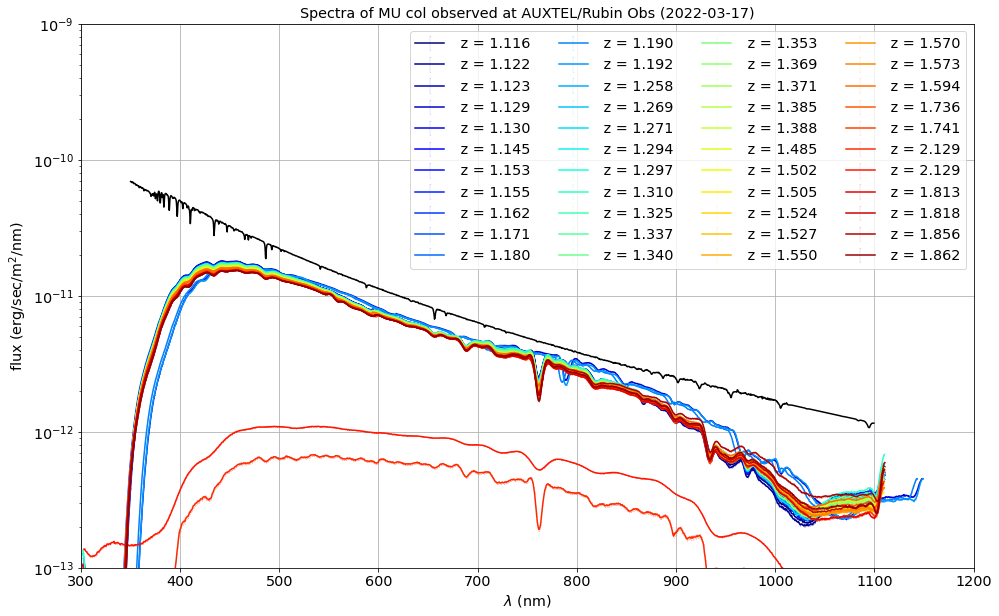

In [38]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    airmassvalue = info.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.3f}"
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df.all_lambdas,the_df.all_fluxes,yerr=the_df.all_fluxes_err, fmt = '-', color=all_colors[ifile],capsize = 0.1, ecolor=all_colors[ifile], elinewidth = .1,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title)
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1200)
ax.set_ylim(1e-13,1e-9)
ax.set_yscale("log")
ax.legend(loc="upper right",ncol=4)

# Convert Not filtered spectra into Mag table

In [39]:
WL,Mags1,EMags1,AirM,Tim = ConvertToImage(info,all_spectra,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL)

/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


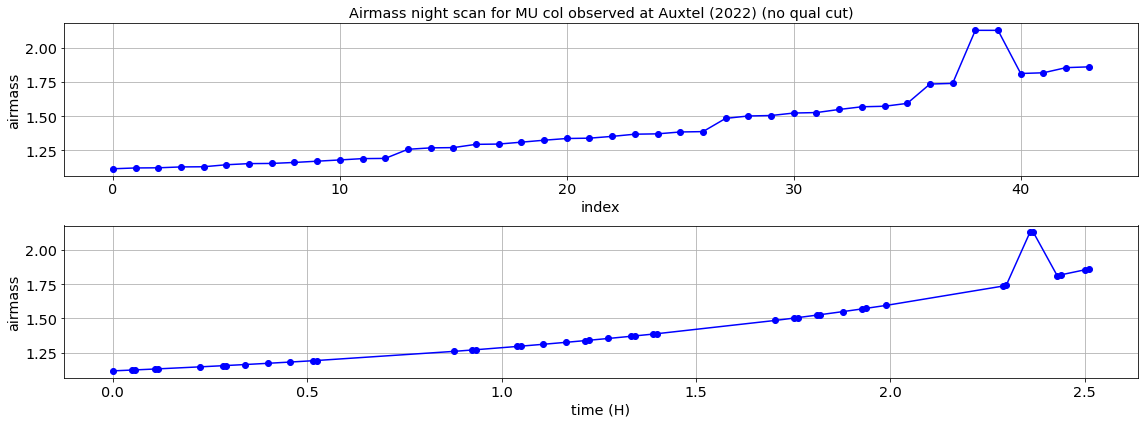

In [40]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(211)
ax1.plot(AirM,"bo-")
ax1.set_ylabel("airmass")
ax1.set_xlabel("index")
title=f"Airmass night scan for {target} observed at Auxtel (2022) (no qual cut)"
ax1.set_title(title)
ax1.grid()


ax2=fig.add_subplot(212)
ax2.plot(Tim,AirM,"bo-")
ax2.set_ylabel("airmass")
ax2.set_xlabel("time (H)")
ax2.grid()

plt.tight_layout()


# Remove bad  spectra

In [41]:
list_of_badnums

[251, 300, 301, 428, 429]

In [42]:
infos, all_spectra =  GetSpectraFiltered(summary_content,list_of_bad_spectra=list_of_badnums)

Remove spectrum 3 for exposure 251
Remove spectrum 11 for exposure 300
Remove spectrum 12 for exposure 301
Remove spectrum 38 for exposure 428
Remove spectrum 39 for exposure 429


In [43]:
infos

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename
0,238,mu. Col,2022-03-18T00:51:22.049,0.000000,1.115575,743.45,8.9,48.0,exposure_2022031700238_postisrccd_spectrum.fits
1,244,mu. Col,2022-03-18T00:54:16.312,0.048406,1.121577,743.45,8.9,49.0,exposure_2022031700244_postisrccd_spectrum.fits
2,245,mu. Col,2022-03-18T00:54:49.235,0.057552,1.122727,743.40,8.8,49.0,exposure_2022031700245_postisrccd_spectrum.fits
3,252,mu. Col,2022-03-18T00:58:20.709,0.116294,1.130309,743.40,8.9,50.0,exposure_2022031700252_postisrccd_spectrum.fits
4,265,mu. Col,2022-03-18T01:04:49.716,0.224352,1.145030,743.30,8.9,53.0,exposure_2022031700265_postisrccd_spectrum.fits
5,272,mu. Col,2022-03-18T01:08:18.080,0.282231,1.153339,743.30,8.9,51.0,exposure_2022031700272_postisrccd_spectrum.fits
6,273,mu. Col,2022-03-18T01:08:50.992,0.291373,1.154683,743.35,8.9,51.0,exposure_2022031700273_postisrccd_spectrum.fits
7,279,mu. Col,2022-03-18T01:11:46.031,0.339995,1.161939,743.40,8.9,53.0,exposure_2022031700279_postisrccd_spectrum.fits
8,286,mu. Col,2022-03-18T01:15:18.583,0.399037,1.171053,743.45,8.9,54.0,exposure_2022031700286_postisrccd_spectrum.fits
9,293,mu. Col,2022-03-18T01:18:45.526,0.456521,1.180249,743.45,9.0,53.0,exposure_2022031700293_postisrccd_spectrum.fits


# Convert Not filtered spectra into Mag table

In [44]:
NBSPECTRA=len(all_spectra)

In [45]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [46]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2022-04-21 15:05:20,497 jns-dagoret.cc.in2p3.fr __main__[1735] INFO  Number of good spectra is 39


In [47]:
indexref = 0
ref_spectrum = all_spectra[indexref]
x0 =  ref_spectrum["all_lambdas"]
y0 =  ref_spectrum["all_fluxes"]
flux0 = np.interp(WL, x0, y0, left=None, right=None, period=None)

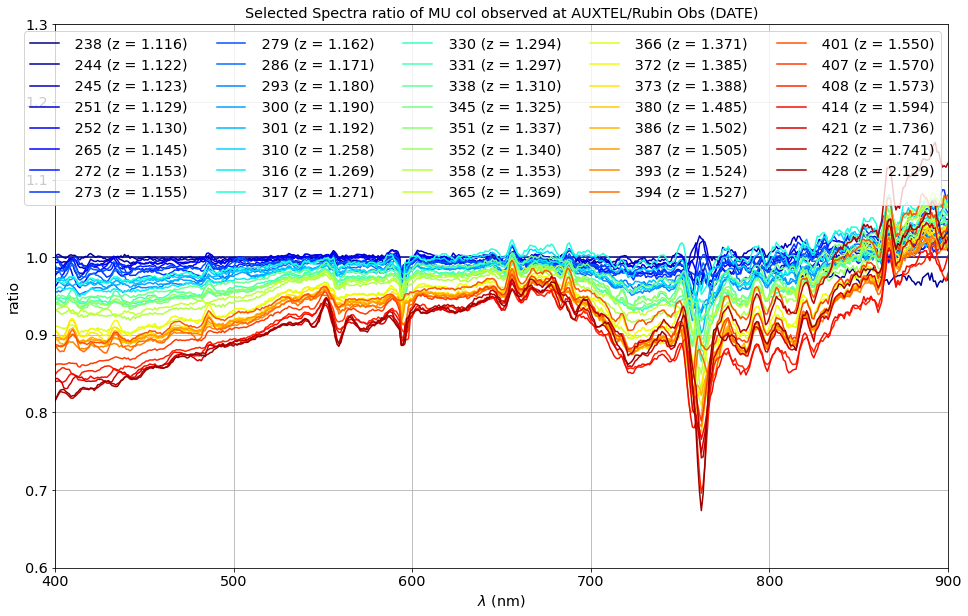

In [48]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    numbervalue = info.iloc[ifile]["number"]
    airmassvalue = info.iloc[ifile]["airmass"]
    label_number_airmass = f" {numbervalue} (z = {airmassvalue:.3f})"

    x =  the_df["all_lambdas"]
    y =  the_df["all_fluxes"]
    flux = np.interp(WL, x, y, left=None, right=None, period=None)
    ratio = flux/flux0
    
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.plot(WL,ratio,color=all_colors[ifile],label= label_number_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
title=f"Selected Spectra ratio of {target} observed at {SITE} (DATE)"
ax.set_title(title)
#ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(400,900)
ax.set_ylim(0.6,1.3)
plt.legend(loc="upper right", ncol=5)
#ax.set_yscale("log")

In [49]:
df = pd.read_csv("data/absorption_pattern.csv")
wlpt,o2,o3,h2o,no2 = atmpatt_Dataf_to_np(df)


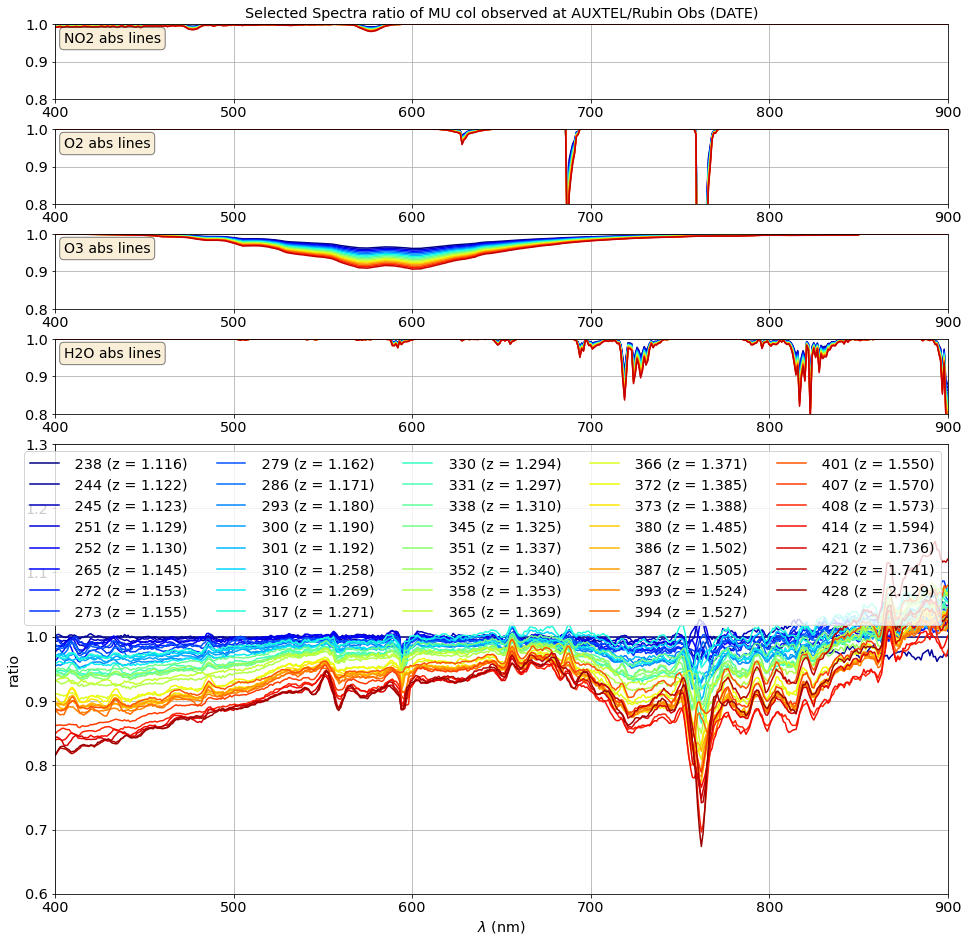

In [52]:
figsize=(16,16)

NOBS = o2.shape[1]
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig=plt.figure(figsize=figsize)
title=f"Selected Spectra ratio of {target} observed at {SITE} (DATE)"


gs = gridspec.GridSpec(5, 1,height_ratios=[0.5,0.5,0.5,0.5,3] ,figure=fig)

# NO2    
ax=fig.add_subplot(gs[0,0])
for index in np.arange(NOBS):   
    ax.plot(wlpt,no2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "NO2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_title(title)
main_ax = ax



# O2    
ax=fig.add_subplot(gs[1,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#ax.set_title(title)


# Ozone
ax=fig.add_subplot(gs[2,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o3[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O3 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# H2O
ax=fig.add_subplot(gs[3,0], sharex=main_ax)

for index in np.arange(NOBS):   
    ax.plot(wlpt,h2o[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.grid()
textstr = "H2O abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# spectrum ratio

ax=fig.add_subplot(gs[4,0], sharex=main_ax)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)



for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    numbervalue = info.iloc[ifile]["number"]
    airmassvalue = info.iloc[ifile]["airmass"]
    label_number_airmass = f" {numbervalue} (z = {airmassvalue:.3f})"

    x =  the_df["all_lambdas"]
    y =  the_df["all_fluxes"]
    flux = np.interp(WL, x, y, left=None, right=None, period=None)
    ratio = flux/flux0
    
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.plot(WL,ratio,color=all_colors[ifile],label= label_number_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")


#ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(400,900)
ax.set_ylim(0.6,1.3)
plt.legend(loc="upper right", ncol=5)
